In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
from glob import glob

import torchvision.transforms as T
from torchvision.datasets.cifar import CIFAR10
from torch.utils.data import DataLoader, Subset
import numpy as np
from torch.nn.parallel import DataParallel
from resnet import ResNet18, ResNet34, ResNet50

In [24]:
class BaseDataset(data.Dataset):
    """docstring for BaseDataset"""

    def __init__(self, config):
        super(BaseDataset, self).__init__()
        self.format = config["format"]
        self.set_filepaths(config["path"])
        self.device = config["device"]

    def set_filepaths(self, path):
        filepaths = path + "/*{}".format(self.format)
        self.filepaths = glob(filepaths)

    def load_batch(self, filepath):
        inp, out = torch.load(filepath, map_location=self.device)
        return inp, out

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        inp, out = self.load_batch(filepath)
        out = nn.functional.log_softmax(out, dim=1)
        return inp, out

    def __len__(self):
        return len(self.filepaths)

In [3]:
def get_model(model_name:str, dset:str, device:torch.device, device_ids:list) -> DataParallel:
        #TODO: add support for loading checkpointed models
        channels = 3 if dset=="cifar10" else 1
        model_name = model_name.lower()
        if model_name == "resnet18":
            model = ResNet18(channels)
        elif model_name == "resnet34":
            model = ResNet34(channels)
        elif model_name == "resnet50":
            model = ResNet50(channels)
        else:
            raise ValueError(f"Model name {model_name} not supported")
        model = DataParallel(model.to(device), device_ids=device_ids)
        return model

In [4]:
def test(model, dloader, loss_fn, device, **kwargs):
        """TODO: generate docstring
        """
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in dloader:
                data, target = data.to(device), target.to(device)
                position = kwargs.get("position", 0)
                output = model(data, position=position)
                test_loss += loss_fn(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                # view_as() is used to make sure the shape of pred and target are the same
                correct += pred.eq(target.view_as(pred)).sum().item()
        acc = correct / len(dloader.dataset)
        return test_loss, acc

In [5]:
def train(model:nn.Module, optim, dloader, loss_fn, device: torch.device, **kwargs):
        """TODO: generate docstring
        """
        model.train()
        train_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(dloader):
            data, target = data.to(device)[0], target.to(device)[0]
            optim.zero_grad()
            position = kwargs.get("position", 0)
            output = model(data, position=position)
            if kwargs.get("apply_softmax", False):
                output = nn.functional.log_softmax(output, dim=1) # type: ignore
            loss = loss_fn(output, target)
            loss.backward()
            optim.step()
            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            # view_as() is used to make sure the shape of pred and target are the same
            if len(target.size()) > 1:
                target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        acc = correct / (len(dloader.dataset) * 128)
        return train_loss, acc

In [46]:
data_config = {
    "format": "node_1.pt",
    "path": "../expt_dump/iid_clients_collab_entropy_cifar10_5clients_5000samples_mvt2_data_log3_distill_epochs_10_steps_2000_position_0_warmup_150_seed2/logs/",
    "device": device
}

dset = BaseDataset(data_config)
indices = np.random.permutation(len(dset))[:112]
dset = Subset(dset, indices)

len(dset)

112

In [47]:
train_loader = DataLoader(dset, batch_size=1, shuffle=True)

dpath = "../imgs/cifar10/"
mean = np.array((0.4914, 0.4822, 0.4465))
std = np.array((0.2023, 0.1994, 0.2010))
test_transform = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(
                    mean, 
                    std
                ),
            ]
        )
test_dset = CIFAR10(root=dpath, train=False, download=False, transform=test_transform)
test_loader = DataLoader(test_dset, batch_size=256)

In [48]:
# initialize a model
device_ids = [0,1,2,3]
device = torch.device(f'cuda:{device_ids[0]}')
model = get_model("resnet34", "cifar10", device, device_ids)
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn_ce = torch.nn.CrossEntropyLoss()
loss_fn_kl = nn.KLDivLoss(reduction="batchmean", log_target=True)

In [ ]:
best_test_acc = 0
# test_acc_l112_ is node 3
test_acc_l112_0, tr_acc_l112_0 = [], []
for epoch in range(1000):
    test_loss, test_acc = test(model, test_loader, loss_fn_ce, device)
    test_acc_l112_0.append(test_acc)
    if best_test_acc < test_acc:
        best_test_acc = test_acc
    tr_loss, tr_acc = train(model, optim, train_loader, loss_fn_kl, device, apply_softmax=True)
    tr_acc_l112_0.append(tr_acc)
    print("epoch {} test_loss: {:.4f}, test_acc: {:.4f}, tr_loss: {:.4f}, tr_acc: {:.4f}".format(epoch,
                                                                                                 test_loss,
                                                                                                 test_acc,
                                                                                                 tr_loss,
                                                                                                 tr_acc))

epoch 0 test_loss: 92.1305, test_acc: 0.1000, tr_loss: 163.3538, tr_acc: 0.3862
epoch 1 test_loss: 86.0791, test_acc: 0.2826, tr_loss: 111.3724, tr_acc: 0.5687
epoch 2 test_loss: 87.4817, test_acc: 0.3326, tr_loss: 84.0677, tr_acc: 0.6604
epoch 3 test_loss: 91.6108, test_acc: 0.3659, tr_loss: 65.1526, tr_acc: 0.7310
epoch 4 test_loss: 78.7095, test_acc: 0.4250, tr_loss: 50.1082, tr_acc: 0.7906
epoch 5 test_loss: 81.2486, test_acc: 0.4359, tr_loss: 38.6297, tr_acc: 0.8344
epoch 6 test_loss: 98.7664, test_acc: 0.3973, tr_loss: 28.6706, tr_acc: 0.8774
epoch 7 test_loss: 78.5866, test_acc: 0.4680, tr_loss: 21.2683, tr_acc: 0.9099
epoch 8 test_loss: 78.6956, test_acc: 0.4604, tr_loss: 17.1580, tr_acc: 0.9254
epoch 9 test_loss: 74.4275, test_acc: 0.5003, tr_loss: 14.0505, tr_acc: 0.9397
epoch 10 test_loss: 77.7697, test_acc: 0.4811, tr_loss: 12.3692, tr_acc: 0.9413
epoch 11 test_loss: 73.7868, test_acc: 0.4975, tr_loss: 10.8956, tr_acc: 0.9461
epoch 12 test_loss: 73.0209, test_acc: 0.5079, t

In [42]:
best_test_acc

0.5898

In [13]:
import matplotlib.pyplot as plt

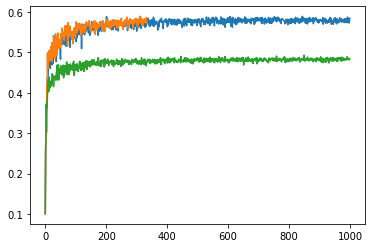

In [45]:
# plt.plot(test_acc_l)
plt.plot(test_acc_l112_0)
plt.plot(test_acc_l112_)
plt.show()

In [17]:
test_acc_l233

[0.1005,
 0.2389,
 0.3197,
 0.3717,
 0.3014,
 0.3813,
 0.3636,
 0.4371,
 0.4232,
 0.4379,
 0.4662,
 0.463,
 0.4747,
 0.498,
 0.4778,
 0.4741,
 0.4608,
 0.4982,
 0.4908,
 0.497,
 0.4852,
 0.4896,
 0.4689,
 0.4756,
 0.5012,
 0.4728,
 0.5,
 0.4967,
 0.5212,
 0.4884,
 0.5239,
 0.5421,
 0.5142,
 0.5046,
 0.5081,
 0.4994,
 0.4774,
 0.5058,
 0.5067,
 0.5167,
 0.5094,
 0.5411,
 0.5198,
 0.5215,
 0.521,
 0.5293,
 0.5164,
 0.5244,
 0.5161,
 0.4995,
 0.4835,
 0.5408,
 0.5437,
 0.5244,
 0.5298,
 0.5327,
 0.5373,
 0.5196,
 0.5384,
 0.532,
 0.5294,
 0.5385,
 0.524,
 0.533,
 0.5448,
 0.5185,
 0.5446,
 0.5373,
 0.5327,
 0.5154,
 0.5235,
 0.5499,
 0.5505,
 0.5435,
 0.5447,
 0.5423,
 0.5356,
 0.5292,
 0.538,
 0.5344,
 0.5332,
 0.5129,
 0.5274,
 0.5414,
 0.5457,
 0.5331,
 0.5501,
 0.5472,
 0.5463,
 0.5461,
 0.5339,
 0.5346,
 0.5406,
 0.533,
 0.5482,
 0.54,
 0.5412,
 0.551,
 0.5363,
 0.5609,
 0.537,
 0.527,
 0.5577,
 0.5448,
 0.5363,
 0.5504,
 0.5531,
 0.5462,
 0.5444,
 0.5535,
 0.5466,
 0.5519,
 0.5588,


In [37]:
test_acc_l112_

[0.1,
 0.2525,
 0.3024,
 0.3254,
 0.3494,
 0.377,
 0.3701,
 0.3926,
 0.4147,
 0.4212,
 0.4312,
 0.4029,
 0.412,
 0.439,
 0.4264,
 0.4225,
 0.4126,
 0.425,
 0.4286,
 0.4244,
 0.4175,
 0.4215,
 0.4282,
 0.4476,
 0.4304,
 0.4425,
 0.4265,
 0.4152,
 0.4226,
 0.441,
 0.4391,
 0.4368,
 0.4366,
 0.4401,
 0.4414,
 0.4311,
 0.4486,
 0.4526,
 0.4687,
 0.455,
 0.4564,
 0.4568,
 0.4322,
 0.4695,
 0.4321,
 0.4462,
 0.4573,
 0.4604,
 0.4524,
 0.456,
 0.4478,
 0.4671,
 0.4504,
 0.4497,
 0.4512,
 0.4442,
 0.4544,
 0.4481,
 0.4554,
 0.4688,
 0.4371,
 0.4522,
 0.4647,
 0.4445,
 0.4676,
 0.46,
 0.4671,
 0.4558,
 0.4599,
 0.4511,
 0.4767,
 0.4513,
 0.4452,
 0.4506,
 0.4707,
 0.4582,
 0.4578,
 0.4448,
 0.4651,
 0.4589,
 0.4692,
 0.4546,
 0.4716,
 0.4628,
 0.4671,
 0.4582,
 0.4635,
 0.4664,
 0.463,
 0.4603,
 0.4734,
 0.4556,
 0.4689,
 0.4785,
 0.4507,
 0.4429,
 0.4531,
 0.4568,
 0.4702,
 0.4629,
 0.4659,
 0.4682,
 0.456,
 0.472,
 0.4709,
 0.4711,
 0.4686,
 0.4589,
 0.4528,
 0.4638,
 0.4594,
 0.4639,
 0.4779